<a href="https://colab.research.google.com/github/Hcardenass/RN_Deteccion_Mascarrillas/blob/main/DMC_ProyectoFinal_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROYECTO INTEGRADOR - DEEP LEARNING
**MODELO DE RECONOCIMIENTO DE MASCARILLAS**


El proyecto es el desarrollo de un Modelo para el Reconocimiento de Mascarillas sobre imágenes. 

Se contiene un conjunto de imágenes donde se estarán revisando si las personas en las imágenes tienen una mascarilla puesta o no.

Integrantes:
*   Joseph Morales
*   Zecarlos Alberto 
*   Hector Cardenas
*   Luis de la Cruz
*   Ilda Rojas



---
Objetivo:


*   Identificar personas con el uso de las mascarillas en las diferentes imágenes cargadas para validar el si las pesonas en las imágenes están cumpliendo o no con la norma (establecida mundialmente por el virus COVID-19)  del uso de la mascarilla.

---

#Desarrollo del Modelo
**Librerias Necesarias para la Creacion del Modelo de Reconocimiento de Mascarillas**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Carga de los datos**

En este caso los datos fueron subidos al colab como un archivo zip.

Se realiza la importación de las imagenes:

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/zz_data_bucket/mask_detection.zip"
#parche para que permita descargar con el mismo nombre del archivo original
data_dir = tf.keras.utils.get_file('mask', origin=dataset_url, extract=True, archive_format='zip')
data_dir = tf.keras.utils.get_file('mask_detection', origin=dataset_url, extract=True, archive_format='zip')
data_dir = pathlib.Path(data_dir)

151322624/151310887 [==============================] - 3s 0us/step


In [ ]:
#image_count = len(list(data_dir.glob('cats/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2387


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/mask_detection')

In [ ]:
!ls  /root/.keras/datasets/mask_detection

no  yes


In [ ]:
!ls  /root/.keras/datasets

mask  mask_detection


# Prueba de visualizar una imagen de cada label

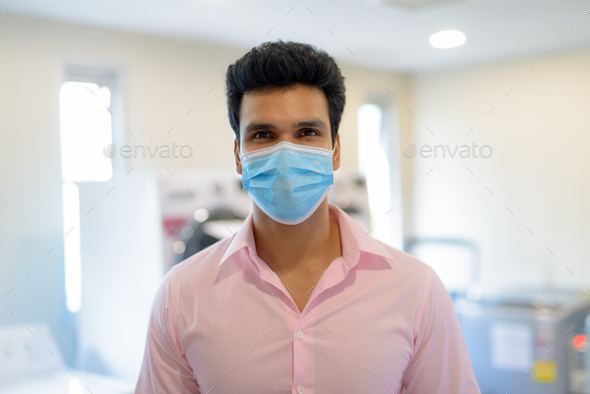

In [ ]:
conmask = list(data_dir.glob('yes/*'))
PIL.Image.open(str(conmask[40]))

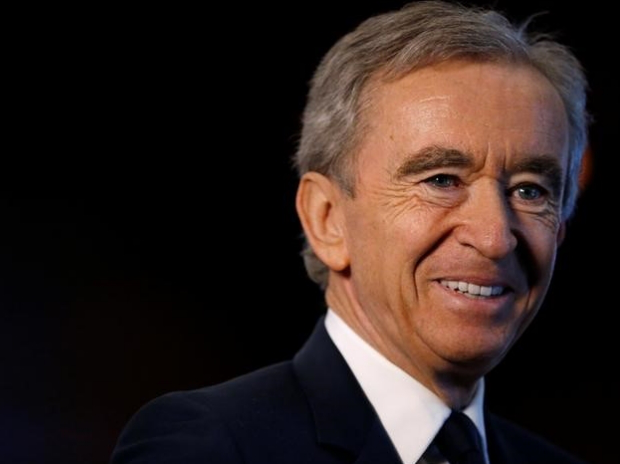

In [ ]:
sinmask = list(data_dir.glob('no/*'))
PIL.Image.open(str(sinmask[1]))

# Creando el conjunto de Datos

Definimos algunos parametros:

In [ ]:
batch_size = 32 #Escoge de 32 en 32 mascarillas 
img_height = 180 #Alto
img_width = 180 #Ancho

Usemos el 80% de las imágenes para entrenamiento y el 20% para validación.

**Entrenamiento**

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2388 files belonging to 2 classes.
Using 1911 files for training.


**Validación**

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2388 files belonging to 2 classes.
Using 477 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


Como podemos ver solo contamos con dos clases, debido a que solo se quiere reconocer si es que usa mascara o no

# Visualizacion de los Datos

Aqui mostraremos las primeras 9 imagenes del conjunto de datos de entrenamiento

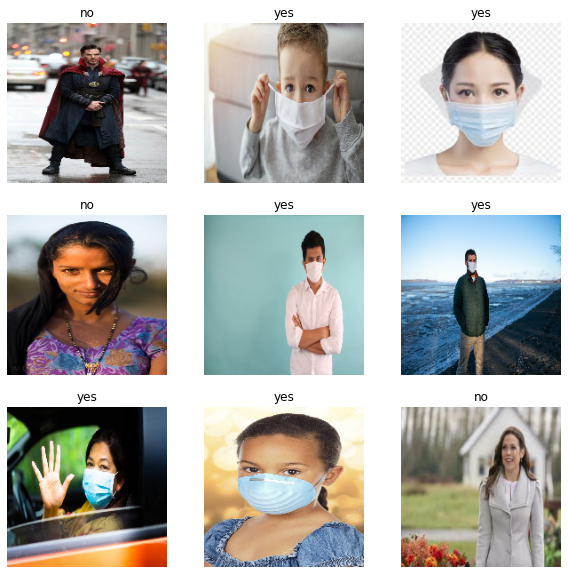

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Entrenaremos un modelo dandole un fit o iteramos para conseguir el batch de la imagen y el batch del label 

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


El `image_batch` es un tensor de la forma` (32, 180, 180, 3) `. Se trata de un lote de 32 imágenes de forma "180x180x3" (la última dimensión se refiere a los canales de color RGB). El `label_batch` es un tensor de la forma` (32,) `, estas son etiquetas correspondientes a las 32 imágenes.


# Configurar el conjunto de datos para el rendimiento

Asegurémonos de utilizar la captación previa en búfer para que pueda obtener datos del disco sin que la E / S se bloquee. Estos son dos métodos importantes que debe utilizar al cargar datos:

- `Dataset.cache` mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear una caché en disco de alto rendimiento.
- `Dataset.prefetch` superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Estandarizar Datos**

Debido a que los valores del canal RGB están en el rango "[0, 255]". Esto no es ideal para una red neuronal; Por lo que estandarizaremos los datos para tener valores de entrada que sean pequeños de entre 0 a 1 

In [ ]:
normalization_layer = layers.Rescaling(1./255)

Hay dos formas de utilizar esta capa. Puede aplicarlo al conjunto de datos llamando a `Dataset.map`, que es bastante utilizado en poder realizar operaciones sin necesidad de iterar  con funcion lambda , donde X y Y son las imagenes y etiquetas respectivamente, este caso solo va a transformar la X que es la imagen con el rescalamiento formando una dupla con Y, esto hace para todas las instancias de la estructura  

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0023967458 1.0


Aca nos muestra el valor minimo y maximo de los datos estandarizados 

# Creando el modelo

Como primer punto se aplica el método Sequential que es usado para modelos de clasificacion  y como input se tendra los datos con rescalamiento con 3 canales(RGB), tambien ,consta de tres bloques de convolución (tf.keras.layers.Conv2D) cada una de ellas tiene 16, 32 y 64 neuronas o filtros respectivamente ,Se usa como Padding a "same" para que en este caso  hago uso de la formula y va a calcular el padding necesario o el relleno de ceros para que esta convolucion siga teniendo el mismo tamaño de alto y ancho de como vino en la entrada , esto tambien cuenta con una capa de agrupación máxima (tf.keras.layers.MaxPooling2D) en cada uno de ellos, asimismo, utilizamos una capa de flaten que lo que haces es tomar el resultado de la capa anterior y aplastarlo convirtiendo en solo un vector y luego agrega una capa densa  (tf.keras.layers.Dense) con 128 neuronas o filtros que se activan mediante una función de activación de ReLU ('relu') que es usado para la solucion de problemas no lineales como que en este caso y para finalizar establecemos una capa densa de salida con 2 neuronas con nuestra variable "num_classes". 


F.Relu: Basicamente mantiene los valores mayores a 0 con el mismo valor pero los negativos los vuelve 0
Ejm:
f(15) = 15
f(-3) = 0

In [ ]:
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compilacion del modelo**

Ahora lo compilamos y preparamos el modelo y establecemos algunas propiedades de como queremos que procese esas matematicas para poder aprender mejor, como funcion de perdida usaremos "SparseCategoricalCrossentropy" que es para modelos de clasificación enfocandose en el indice de la categoria o label para realizar la predicción, ademas tambien usaremos el optimizador Adam que permite a la red como ajustar los pesos y sesgos eficientemente para que aprenda y no desaprenda. y finalmente establecemos una metrica que es el accuracy

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Resumen del Modelo

Usamos Summary para poder ver todas las capas o arquitectura de la red del modelo

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Vemos que son casi 4 millones de parametros todos se van aprender.

# Entrenando el modelo

Ahora para entrenar el modelo establecemos el numero de epocas que queremos que aprenda, en este caso establecimos 10 , aplicamos fit a nuestros datos de entrenamiento y de validacion.

Dandonos un accuracy del 97% y en la validacion el 74% 

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
60/60 [==============================] - 56s 922ms/step - loss: 0.6625 - accuracy: 0.6259 - val_loss: 0.5217 - val_accuracy: 0.7631
Epoch 2/10
60/60 [==============================] - 53s 890ms/step - loss: 0.5114 - accuracy: 0.7551 - val_loss: 0.4819 - val_accuracy: 0.7736
Epoch 3/10
60/60 [==============================] - 53s 889ms/step - loss: 0.4609 - accuracy: 0.7729 - val_loss: 0.5058 - val_accuracy: 0.7526
Epoch 4/10
60/60 [==============================] - 53s 888ms/step - loss: 0.3895 - accuracy: 0.8263 - val_loss: 0.5215 - val_accuracy: 0.7526
Epoch 5/10
60/60 [==============================] - 53s 890ms/step - loss: 0.3195 - accuracy: 0.8660 - val_loss: 0.5610 - val_accuracy: 0.7421
Epoch 6/10
60/60 [==============================] - 53s 892ms/step - loss: 0.2218 - accuracy: 0.9189 - val_loss: 0.5720 - val_accuracy: 0.7463
Epoch 7/10
60/60 [==============================] - 53s 891ms/step - loss: 0.1670 - accuracy: 0.9362 - val_loss: 0.8428 - val_accuracy: 0.7442

# Visualización del Modelo

Creamos gráficos de pérdida y precisión en los conjuntos de entrenamiento y validación:

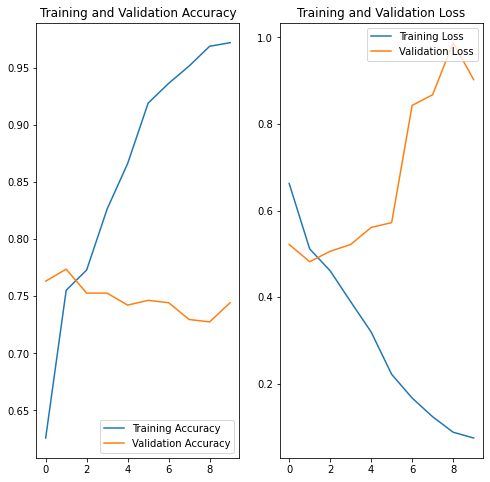

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Los gráficos muestran que la precisión del entrenamiento y la precisión de la validación están fuera de lugar por grandes márgenes, y el modelo ha logrado solo alrededor del 75% de precisión en el conjunto de validación.

Inspeccionemos qué salió mal e intentemos aumentar el rendimiento general del modelo. Utilizando lo que llamos Aumento de datos

# Interpretacion del Accuracy
si visualizamos vemos que los datos no estan en el escenario que quisieramos, la precisión si vemos los datos de entrenamiento suben mucho pero es basicamente porque esta aprendiendo el modelo , pero en los datos del set de pruebas o validacion es malo

#Interpretacion de la Perdida
En la perdida del set de entrenamiento cada vez es menor lo cual parece que es bueno pero en el set de pruebas aumenta en pocas palabras se aprende los datos de entrenamiento y con eso funciona pero no sirve en el mundo real, esto pasa por algo que se llama sobre ajuste que se aprende de memoria los datos de entrenamiento y no puede generalizar y con datos de prueba o mundo real ira mal 

**Interpretacion del Sobreajuste o Overfitting que tuvo el modelo**

En los gráficos anteriores, la precisión del entrenamiento aumenta linealmente con el tiempo, mientras que la precisión de la validación se detiene alrededor del 75% en el proceso de entrenamiento. Además, la diferencia de precisión entre el entrenamiento y la precisión de la validación es notable, una señal de Sobreajuste

Cuando hay una pequeña cantidad de ejemplos de entrenamiento, el modelo a veces aprende de ruidos o detalles no deseados de ejemplos de entrenamiento, hasta el punto que impacta negativamente el desempeño del modelo en nuevos ejemplos. Este fenómeno se conoce como sobreajuste. Significa que el modelo tendrá dificultades para generalizar en un nuevo conjunto de datos.


# Data Augmentation

El Aumento de datos adopta el enfoque de generar datos de entrenamiento adicionales a partir de sus ejemplos existentes al aumentarlos mediante transformaciones aleatorias que producen imágenes de aspecto creíble. Esto ayuda a exponer el modelo a más aspectos de los datos y a generalizar mejor.

Implementaremos el aumento de datos usando las siguientes capas de preprocesamiento de Keras: `tf.keras.layers.RandomFlip`,` tf.keras.layers.RandomRotation` y `tf.keras.layers.RandomZoom`. Estos pueden incluirse dentro de su modelo como otras capas y ejecutarse en la GPU

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualicemos cómo se ven algunos ejemplos aumentados aplicando el aumento de datos a la misma imagen varias veces:

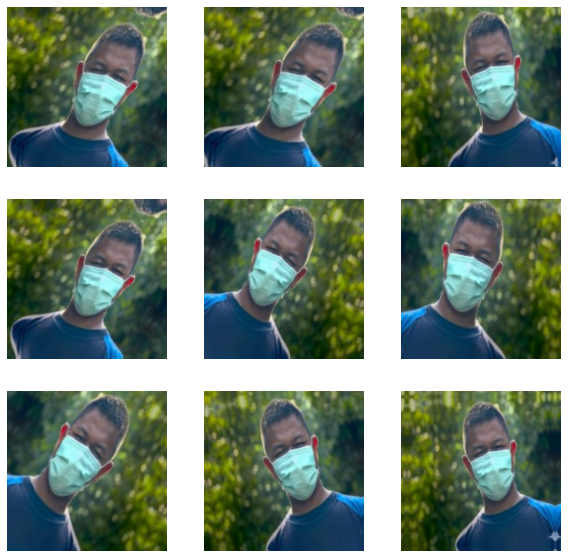

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Visualizamos que las imagenes ahora tienen una rotacion y un acercamiento.

# Dropout

Es basicamente poder inactivar algunas neuronas de la capa previa con la finalidad de que estas dejen aprender a otras neuronas que si estan activadas y de alguna forma entre todas puedan aprender igual. 

Significa que durante el entrenamiento en cada una de las epocas o ciclos de entrenamiento las neuronas tendran un 20% de probabilidad de desactivarse esto se usa ya que aveces despues del entrenamiento al ver el pesos de las redes algunos son muy grandes

**Creacion del modelo con aumento de datos y Dropout**

Se hara la creacion del modelo con las misma cantidad de neuronas, nucleos y funciones de activacion pero ya añadiendo caumento de datos y la funcion de activacion Dropout

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Volvemos a la compilacion del modelo**

Aplicamos el mismo optimizador "Adam" y la misma funcion de perdida "SparseCategoricalCrossentropy".

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

# Re-Entrenamos el modelo

Ahora para entrenar el modelo establecemos el numero de epocas que queremos que aprenda, en este caso establecimos 15 , aplicamos fit a nuestros datos de entrenamiento y de validacion.

Dandonos un accuracy del 83% y en la validacion el 84% 

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
60/60 [==============================] - 63s 1s/step - loss: 0.7141 - accuracy: 0.5646 - val_loss: 0.6673 - val_accuracy: 0.6101
Epoch 2/15
60/60 [==============================] - 62s 1s/step - loss: 0.6306 - accuracy: 0.6358 - val_loss: 0.5438 - val_accuracy: 0.7254
Epoch 3/15
60/60 [==============================] - 62s 1s/step - loss: 0.6203 - accuracy: 0.6698 - val_loss: 0.6338 - val_accuracy: 0.6667
Epoch 4/15
60/60 [==============================] - 62s 1s/step - loss: 0.5829 - accuracy: 0.6756 - val_loss: 0.5470 - val_accuracy: 0.7254
Epoch 5/15
60/60 [==============================] - 62s 1s/step - loss: 0.5403 - accuracy: 0.7295 - val_loss: 0.4818 - val_accuracy: 0.7715
Epoch 6/15
60/60 [==============================] - 63s 1s/step - loss: 0.5182 - accuracy: 0.7436 - val_loss: 0.4780 - val_accuracy: 0.7631
Epoch 7/15
60/60 [==============================] - 62s 1s/step - loss: 0.4901 - accuracy: 0.7619 - val_loss: 0.4850 - val_accuracy: 0.7862
Epoch 8/15
60/60 [==

# Visualización del Modelo

Después de aplicar el aumento de datos y `tf.keras.layers.Dropout`, hay menos sobreajuste que antes, y la precisión del entrenamiento y la validación están más alineadas:

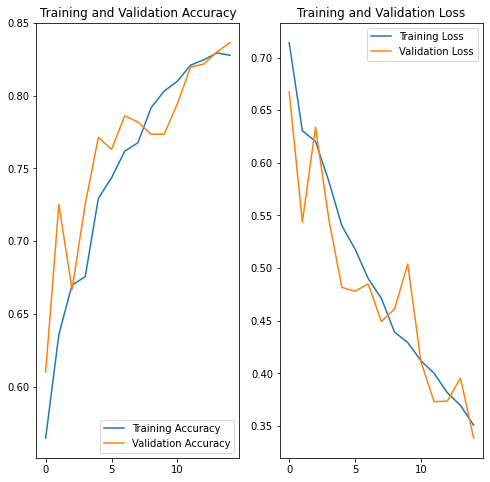

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Interprertacion del Accuracy y de la perdida

Este es el escensario que esperamos ya que observamos en la precision de los datos de entrenamiento y de validacion van subiendo constantemente ambos juntos hasta llegar al 83 y  84% respectivamente e igual en la perdida ambos van cayendo juntos , esto demuestra que esta aprendiendo y no esta sufriendo un sobre ajuste  y podra realizar mejores predicciones 

# Predicción

Ahora procedemos a realizar la prediccion , como ejemplo tomaremos la imagen 769 y nos dice que hay un 99.45% de confianza de que **SI** sea una imagen con donde reconoce que hay mascarilla. Para confirmar abrimos la imagen y nos muestra la de un niño con mascarilla. Aseguandonos de que la prediccion fue correcta.

In [ ]:
#Ejemplo 1 con mascara
input_url = "https://storage.googleapis.com/zz_data_bucket/769.jpg"
input_path = tf.keras.utils.get_file('769', origin=input_url)

#input_url = "https://storage.googleapis.com/zz_data_bucket/41.jpg"
#input_path = tf.keras.utils.get_file('769', origin=input_url)

#Ejemplo 2 sin mascara
#input_url = "https://storage.googleapis.com/zz_data_bucket/5.jpg"
#input_path = tf.keras.utils.get_file('1111', origin=input_url)


img = tf.keras.utils.load_img(
    input_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

40960/31991 [======================================] - 0s 0us/step
This image most likely belongs to yes with a 99.45 percent confidence.


In [ ]:
class_names

['no', 'yes']

In [ ]:
np.argmax(score)

1

In [ ]:
np.max(score)

0.9944667

In [ ]:
score

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00553326, 0.9944667 ], dtype=float32)>

#Conclusiones

Desarrollar proyectos de Deep Learning hoy en día dentro de las empresas, es muy importante para contar con la ventaja que nos dan los datos, imagénes y demás (conjuntos de datos, no estructurados) para dar el siguiente paso en cuanto a las tomas de decisiones. 

1. El proyecto nos permite, a travéz de un conjunto de imágenes, hacer el estudio de si las imágenes cuentan con la particularidad de que las personas tengan o no una mascarilla.  Dando como resultado la identificación de estás imágenes, y que el modelo desarrollado ha cumplido con el objetivo establecido dentro de nuestro proyecto.  Permitiendo con el resultado la toma de decisiones sobre las personas que no utilizan la mascarillas. 

2. Para empresas donde se debe tener control del uso riguroso de las máscarillas u otro identificador en las personas, la creación de modelos permiten que se pueda tomar las medidas pertinentes para los casos donde las personas no están cumpliendo con la norma o no. El uso en particular la librería Tersorflow ha permitido el desarrollo y entendimiento en la práctica de la aplicación de modelos para Deep Learning. 

3. En el desarrollo del modelo se logra hacer la identificación de la necesidad de ajustes para aumentar el rendimiento del modelo.  Es importante hacer las pruebas e inspeccionemos del modelo; y además de tener conocimientos de las  diferentes opciones que contamos para hacer los ajustes requeridos y tener como resultado un Modelo confiable. 

4. El idenficación y pasos ha realizar en el desarrollo del proyecto ha sido la clave para el resultado del modelo y el cual quedá mostrado en la ejecución del Predicción, donde tenemos el resultado de 99.45% para la imagen analizada.
